# Data loading and preprocessing

In [1]:
import os
import pandas as pd
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
folders = {
    'demented': 1,
    'non_demented': 0
}

data = []
base_path = 'Aug_OASIS'

# Collecting image file paths and labels
for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            data.append({
                'file_path': os.path.join(folder_path, file),
                'label': label
            })

df = pd.DataFrame(data)

print(df.head(5))
print(df.shape)
print(df['label'].value_counts())


                                           file_path  label
0  Aug_OASIS/demented/aug_33835_OAS1_0039_MR1_mpr...      1
1  Aug_OASIS/demented/aug_58765_aug_47286_OAS1_02...      1
2     Aug_OASIS/demented/OAS1_0023_MR1_mpr-3_127.jpg      1
3  Aug_OASIS/demented/aug_21481_OAS1_0335_MR1_mpr...      1
4  Aug_OASIS/demented/aug_55549_aug_41841_aug_247...      1
(134444, 2)
label
1    67222
0    67222
Name: count, dtype: int64


In [3]:
# Define the dataset class
class SimpleMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)
        return image, label

In [4]:
# Define transformations
transformations = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize((0.1266,), (0.1600,))  # Normalization
])

In [5]:
# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [6]:
# Create datasets and DataLoader objects
train_dataset = SimpleMRIDataset(train_df, transform=transformations)
val_dataset = SimpleMRIDataset(val_df, transform=transformations)
test_dataset = SimpleMRIDataset(test_df, transform=transformations)

In [7]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Print the number of images in each dataset
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")


Number of images in the training dataset: 107555
Number of images in the validation dataset: 13444
Number of images in the test dataset: 13445


## Show images

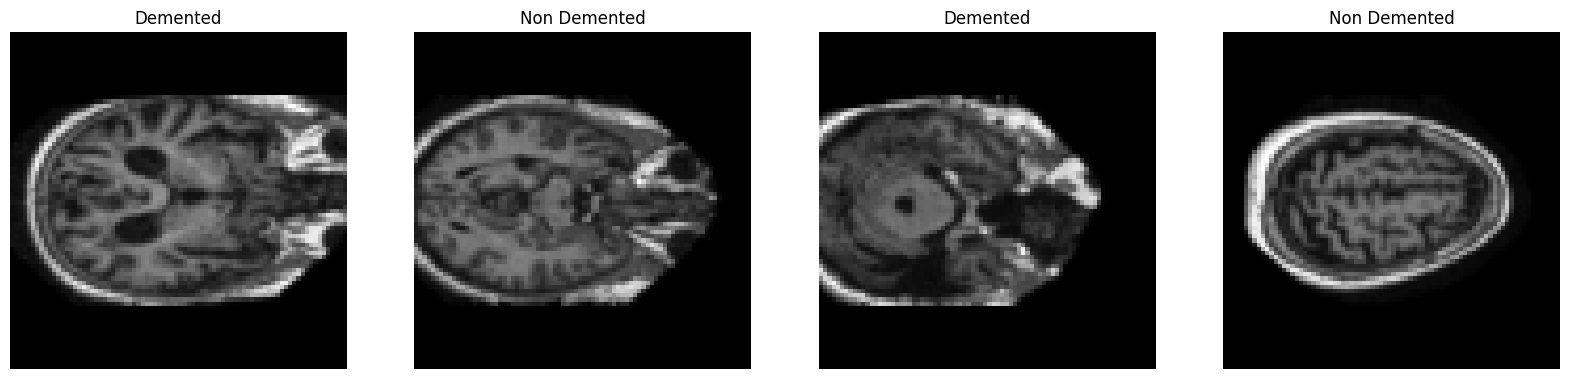

In [9]:
def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.1266 + 0.1600, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


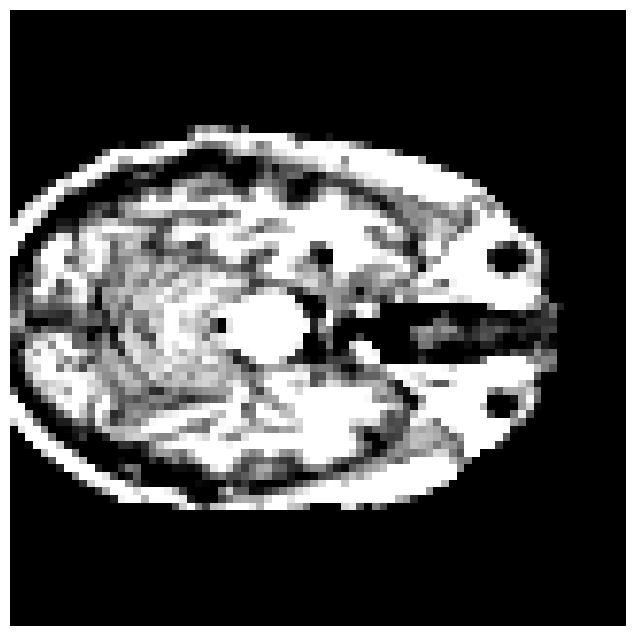

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_single_large_image(loader):
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the figure size as needed
    
    for images, labels in loader:
        image, label = images[0], labels[0]  # Just take the first image and label
        img = image.numpy()  # Convert to numpy array
        img = np.transpose(img, (1, 2, 0))  # Rearrange the dimensions
        
        # Assuming the image is grayscale, replicate the single channel to RGB
        # This step is optional and can be adjusted based on your specific needs
        if img.shape[2] == 1:  # Check if the last dimension is 1
            img = np.repeat(img, 3, axis=2)  # Repeat the grayscale values across 3 channels
        
        ax.imshow(img, cmap='gray')  # Display the image in grayscale
        #label_text = 'Non Demented' if label == 0 else 'Demented'
        #ax.set_title(label_text)
        ax.axis('off')
        break  # Only show the first image

show_single_large_image(train_loader)


# Model

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=2, stride=2, padding=1)  # Reduced filters and smaller kernel size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Additional pooling layer
        self.dropout1 = nn.Dropout(0.6)  # Further increased dropout rate
        self.fc1 = nn.Linear(6 * 10 * 10, 64)  # Reduced complexity even more
        self.dropout2 = nn.Dropout(0.8)  # Further increased dropout before the final layer
        self.fc2 = nn.Linear(64, 2)  # Adjusted due to the change in fc1
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool2(x)  # Applying the additional pooling
        x = self.dropout1(x)
        x = x.view(-1, 6 * 10 * 10)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

In [12]:
# Function to compute the size of the model
def get_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/(1024*1024)  # Size in MB
    os.remove('temp.p')  # Remove the temp file
    return model_size

# Function to calculate AUC score
def calculate_auc(model, loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_scores.extend(outputs[:,1].tolist())
            y_true.extend(labels.tolist())
    auc_score = roc_auc_score(y_true, y_scores)
    return auc_score

# Training Loop with tqdm, and tracking
num_epochs = 20
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # AUC scores
    train_auc = calculate_auc(model, train_loader)
    val_auc = calculate_auc(model, val_loader)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}')

end_time = time.time()
training_time = end_time - start_time

model_size = get_model_size(model)

# Testing AUC
test_auc = calculate_auc(model, test_loader)

print(f"Training completed in: {training_time:.2f}s")
print(f"Model size: {model_size:.2f}MB")
print(f"Test AUC: {test_auc:.4f}")

# At this point, you can plot the train_losses, val_losses, train_auc_scores, and val_auc_scores over epochs to visualize the training and validation process.


Epoch 1/20:   0%|          | 0/6723 [00:00<?, ?batch/s]

Epoch 1/20: 100%|██████████| 6723/6723 [06:56<00:00, 16.15batch/s]


Epoch [1/20], Loss: 0.4659, Val Loss: 0.3540, Train AUC: 0.9339, Val AUC: 0.9356


Epoch 2/20: 100%|██████████| 6723/6723 [06:31<00:00, 17.16batch/s]


Epoch [2/20], Loss: 0.3998, Val Loss: 0.3342, Train AUC: 0.9451, Val AUC: 0.9464


Epoch 3/20: 100%|██████████| 6723/6723 [06:38<00:00, 16.89batch/s]


Epoch [3/20], Loss: 0.3854, Val Loss: 0.3310, Train AUC: 0.9458, Val AUC: 0.9468


Epoch 4/20: 100%|██████████| 6723/6723 [05:58<00:00, 18.77batch/s]


Epoch [4/20], Loss: 0.3785, Val Loss: 0.3060, Train AUC: 0.9484, Val AUC: 0.9494


Epoch 5/20: 100%|██████████| 6723/6723 [05:31<00:00, 20.26batch/s]


Epoch [5/20], Loss: 0.3706, Val Loss: 0.3010, Train AUC: 0.9560, Val AUC: 0.9574


Epoch 6/20: 100%|██████████| 6723/6723 [05:54<00:00, 18.99batch/s]


Epoch [6/20], Loss: 0.3673, Val Loss: 0.2963, Train AUC: 0.9579, Val AUC: 0.9587


Epoch 7/20: 100%|██████████| 6723/6723 [06:30<00:00, 17.22batch/s]


Epoch [7/20], Loss: 0.3616, Val Loss: 0.2829, Train AUC: 0.9618, Val AUC: 0.9617


Epoch 8/20: 100%|██████████| 6723/6723 [06:12<00:00, 18.05batch/s]


Epoch [8/20], Loss: 0.3604, Val Loss: 0.2950, Train AUC: 0.9599, Val AUC: 0.9594


Epoch 9/20: 100%|██████████| 6723/6723 [05:31<00:00, 20.28batch/s]


Epoch [9/20], Loss: 0.3566, Val Loss: 0.2912, Train AUC: 0.9599, Val AUC: 0.9609


Epoch 10/20: 100%|██████████| 6723/6723 [05:42<00:00, 19.61batch/s]


Epoch [10/20], Loss: 0.3540, Val Loss: 0.3757, Train AUC: 0.9408, Val AUC: 0.9414


Epoch 11/20: 100%|██████████| 6723/6723 [05:06<00:00, 21.95batch/s]


Epoch [11/20], Loss: 0.3508, Val Loss: 0.2814, Train AUC: 0.9614, Val AUC: 0.9621


Epoch 12/20: 100%|██████████| 6723/6723 [03:02<00:00, 36.89batch/s]


Epoch [12/20], Loss: 0.3550, Val Loss: 0.2825, Train AUC: 0.9629, Val AUC: 0.9636


Epoch 13/20: 100%|██████████| 6723/6723 [03:01<00:00, 36.98batch/s]


Epoch [13/20], Loss: 0.3512, Val Loss: 0.2811, Train AUC: 0.9655, Val AUC: 0.9661


Epoch 14/20: 100%|██████████| 6723/6723 [03:02<00:00, 36.80batch/s]


Epoch [14/20], Loss: 0.3495, Val Loss: 0.2739, Train AUC: 0.9632, Val AUC: 0.9640


Epoch 15/20: 100%|██████████| 6723/6723 [03:28<00:00, 32.27batch/s]


Epoch [15/20], Loss: 0.3480, Val Loss: 0.2802, Train AUC: 0.9646, Val AUC: 0.9655


Epoch 16/20: 100%|██████████| 6723/6723 [03:53<00:00, 28.77batch/s]


Epoch [16/20], Loss: 0.3457, Val Loss: 0.2765, Train AUC: 0.9634, Val AUC: 0.9641


Epoch 17/20: 100%|██████████| 6723/6723 [04:16<00:00, 26.21batch/s]


Epoch [17/20], Loss: 0.3455, Val Loss: 0.2893, Train AUC: 0.9642, Val AUC: 0.9650


Epoch 18/20: 100%|██████████| 6723/6723 [04:38<00:00, 24.15batch/s]


Epoch [18/20], Loss: 0.3459, Val Loss: 0.2661, Train AUC: 0.9654, Val AUC: 0.9664


Epoch 19/20: 100%|██████████| 6723/6723 [05:03<00:00, 22.16batch/s]


Epoch [19/20], Loss: 0.3454, Val Loss: 0.2736, Train AUC: 0.9653, Val AUC: 0.9655


Epoch 20/20: 100%|██████████| 6723/6723 [05:28<00:00, 20.48batch/s]


Epoch [20/20], Loss: 0.3444, Val Loss: 0.2693, Train AUC: 0.9679, Val AUC: 0.9693
Training completed in: 13107.38s
Model size: 0.15MB
Test AUC: 0.9680


# Metrics

In [13]:
# Function to calculate predictions and true labels
def get_predictions_and_labels(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_scores.extend(outputs[:, 1].tolist())  # Probabilities for the positive class
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    return y_true, y_pred, y_scores

# Get predictions and true labels for the test set
y_true, y_pred, y_scores = get_predictions_and_labels(model, test_loader)

# Classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6723
           1       0.98      0.77      0.86      6722

    accuracy                           0.88     13445
   macro avg       0.89      0.88      0.88     13445
weighted avg       0.89      0.88      0.88     13445



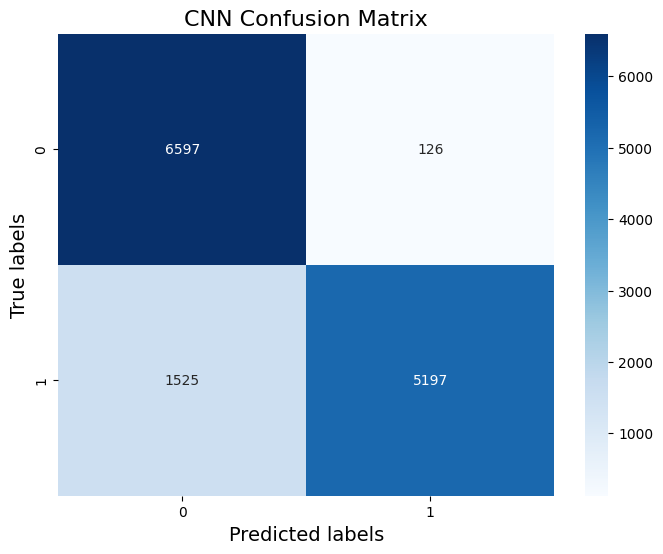

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels', fontdict={'size':14})
ax.set_ylabel('True labels', fontdict={'size':14})
ax.set_title('CNN Confusion Matrix', fontdict={'size':16})
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

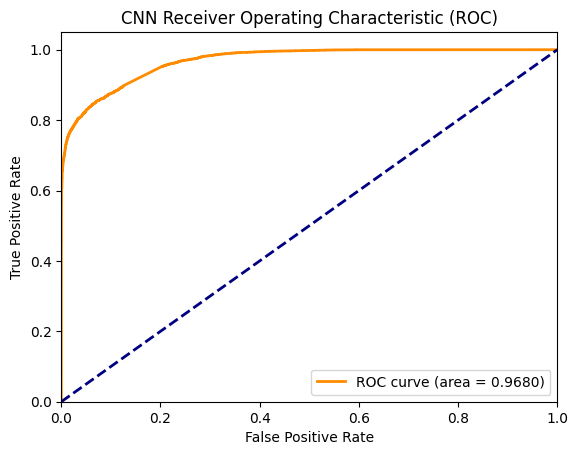

In [15]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()